# `keyfi`: a simple tutorial

`keyfi` is a python package for key feature indentification in high-dimensional datasets. This is done in three steps:

1. Dimensionaliy reduction (in `dimred.py`): by using UMAP or TSNE a high-dimensional dataset can be mapped into a low-dimensional (2D) manifold. This embedding is done such that the distances between points in high dimensions is preserved in the low-dimensional mapping as much as possible.

2. Unsupervised clustering (in `cluster.py`): employing HDBSCAN or KMeans different regions in the low-dimensional mapping (called clusters) can be identified.

3. Feature correlation: mutual information (in `mi.py`) allows to find the most important variables in each cluster of the two dimensional mapping.

In this notebook, we will walk through the core functionality of this post-processing workflow and compare the key features identified by `keyfi` with different available algorithms.

### The default workflow with UMAP, HDBSCAN and MI

First, lets import the `keyfi` module. This requires installing the `keyfi` package, which can be done following the instructions in the `README.rst` in the root folder. We will also import the four main algorithms that we will be testing. These are imported by deafult by dimred so we can import them from here. Please note that this may take a little while.

In [1]:
import keyfi as kf

from keyfi.dimred import UMAP
from keyfi.dimred import TSNE
from keyfi.cluster import HDBSCAN
from keyfi.cluster import KMeans

Note that the four main algorithms can also be accessed directly without explicitly including the final four lines of code, albeit in a more verbose manner, as you can see below:

In [2]:
all([
    UMAP == kf.dimred.UMAP,
    TSNE == kf.dimred.TSNE,
    HDBSCAN == kf.cluster.HDBSCAN,
    KMeans == kf.cluster.KMeans
])

True

Now we need to load the data. For this quick demo, we will import the coarsest mesh available in the `./input` folder. This dataset is a 2D slice of an instantaneous LES simulation of the oxidation of nitrogen oxides by ozone. Here, the dataset is in VTK format and has been resampled in Paraview to a regular grid as the VTK format is more straight forward with a regular grid. There is also a medium and fine version of this VTK slice, which you can test, but be aware that runtimes can increase considerably. You can also export your 2D slice or 3D mesh without any changes (i.e. non-regular meshes) in VTM format directly from Paraview. This will also create a VTM and a VTP file inside a folder with the same name as your mesh file. Both are required for the import function to work. You can see an example in the `./input` folder.

We will do this with the `import_vtk_data` function. Note that there is an option in import data in CSV format with the `import_csv_data` function. Note that with this approach you will not be able to export the final cluster locations as a VTK file. This is only supported if the input data is in VTK (or VTM) format.

In [3]:
path_input = './input/2D_coarse.vtk'
data, mesh = kf.import_vtk_data(path_input)

In the next steo we use the `clean_data` function to clean up the input VTK data. Basically this eliminates the $U_z$ velocity component if your data is 2D and also remove the ghost type variable exported by default in Paraview when you save a resampled mesh as VTK. You just have to provide the dimension of your data (2 for 2D and 3 for 3D) and, optionally, other variables that you wish to drop. This can be usefull for seeing the effect of different variable sets in the key features identified by `keyfi`. In this first run we will keep all the variables we exported from our original simulation data. This includes 13 diffeent variables for 6457 points.

In [4]:
cleaned_data = kf.clean_data(data, dim=2, vars_to_drop=None)
cleaned_data.shape

(6457, 13)

Let's have a look at `cleaned_data` to which which variables it includes, plus some basic statistical description of each variable for all the points in the 2D mesh dataset.

In [5]:
cleaned_data.describe()

,X_N2O4,T,X_N2,X_N2O3,X_N2O5,X_NO,X_NO2,X_NO3,X_O,X_O2,X_O3,U:0,U:1
count,6.457000e+03,6457.000000,6457.000000,6.457000e+03,6457.000000,6.457000e+03,6.457000e+03,6.457000e+03,6.457000e+03,6457.000000,6.457000e+03,6457.000000,6457.000000
mean,1.237202e-08,344.211236,0.789937,1.309244e-10,0.000006,3.369252e-05,1.882885e-04,2.309953e-08,4.186671e-10,0.209612,2.228991e-04,0.023168,0.182876
std,5.455458e-09,0.450517,0.000099,2.831473e-10,0.000005,8.271911e-05,6.058755e-05,1.483656e-08,3.865371e-10,0.000068,1.942403e-04,4.202958,2.310654
min,0.000000e+00,343.149994,0.789640,0.000000e+00,0.000000,1.270167e-37,2.913219e-35,0.000000e+00,1.079128e-35,0.209460,2.297829e-30,-8.943175,-8.386618
25%,8.788284e-09,344.069580,0.789915,8.614983e-13,0.000002,1.265660e-07,1.649442e-04,7.932297e-09,2.565853e-10,0.209589,1.406217e-04,-1.504012,-0.314416
50%,1.460612e-08,344.494141,0.789951,4.932285e-12,0.000006,7.885238e-07,2.154398e-04,2.689644e-08,2.876207e-10,0.209654,1.568572e-04,-1.139554,-0.044570
75%,1.611789e-08,344.526611,0.789958,7.406616e-11,0.000010,1.090240e-05,2.263047e-04,3.530326e-08,4.725181e-10,0.209661,2.569443e-04,-0.534866,0.133664
max,2.069169e-08,344.555023,0.790140,1.027067e-09,0.000017,3.000004e-04,2.565972e-04,5.333058e-08,1.802885e-09,0.209666,8.999985e-04,25.833288,24.055782


Here, we will apply the UMAP dimensionalty reduction algorithm to the cleaned dataset. The parameters chosen can be changed but the currently selected values give a good low-dimensional mapping. To explore the UMAP algorithm further check out the `umap_tutorial.ipynb` notebook in the `algorithms` folder or read the [official documentation](https://umap-learn.readthedocs.io/en/latest/index.html).

In [6]:
embedding, mapper = kf.embed_data(
    data=cleaned_data,
    algorithm=UMAP,
    scale=True,
    n_neighbors=100,
    min_dist=0.1,
    random_state=0,
    n_components=2,
    init="spectral"
)

Apply scaling for all features.

Data reduction using algorithm: UMAP....



OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


done in 28.860s.



##### Parameter selection:

The three main parameters here when using UMAP are `n_neighbors`, `min_dist`, and  `init`. Although each problem is different, we can use a some rule of thumb to get values for them that are quite useful.

- `n_neighbors`: this value selects the number of neighbors $n_n$ that UMAP will use for defining the data structure. As a general rule, if $N$ is the total number of points in your dataset, a good starting value for the number of neighbors can be found by: $n_n \sim \sqrt{N}$.
- `min_dist`: this value defines, quite literally, the minimum distance at which points in the low-dimensional manifold are allowed to be, within the range $0 \leq d_{min} \leq 1$. As a general rule, CFD simulations with large ammounts of points create a better low dimensional manifold with lower values of minimum distance. This is because if points similar points are separated too much, the clusters become less tightly packed and are harder to identidy. The range $0 \leq d_{min} \leq 0.2$ usually is a good starting point, with larger simulations favouring lower values. If unsure, $d_{min} = 0.1$ should produce good results.
- `init`: this selects the initialization algorithm from 'random', 'spectral', 'array' for the UMAP. Default is 'spectral'; When 'array' is chosen, PCA is used with params = {svd_solver='full', random_state = 0}, unlike the defalt PCA parameter in t-SNE API.

Let's take a look at the two output variables `embedding` and `mapper`:

In [7]:
print(f'{embedding} \n\n {mapper}')

[[14.946133  15.551802 ]
 [14.91898   15.520214 ]
 [14.892213  15.43306  ]
 ...
 [ 1.0274701  3.10283  ]
 [ 0.9245442  3.0475523]
 [ 1.3782098  3.0719614]] 

 UMAP(dens_frac=0.0, dens_lambda=0.0, n_neighbors=100, random_state=0)


As you can see, `embedding` stores the values of the two (note how `n_components = 2`) low-dimensional 'synthetic' variables computed by UMAP for each point in the mesh, while `mapper` is the UMAP object that has made the mapping operation. It includes all setting defined by the `embed_data` function.

Let's plot the embedding to see what it looks like:

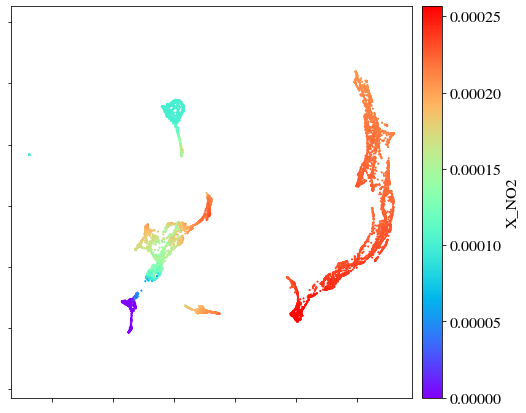

In [8]:
kf.plot_embedding(
    embedding=embedding, 
    data=cleaned_data, 
    scale_points = True,
    cmap_var='X_NO2',
    cmap_minmax=[]
)

The scatter plot for the two UMAP components is colored here by the concentration of NO2 (feel free to try other variables and different ranges!). We can already see that UMAP has done a good job in grouping points into dense regions and separating these regions from each other. Note that the axes are removed as the values exact vales for the two components are not interpretable in any significant way. Therefore, this low-dimensional mapping should be evaluated by the sizes, shapes, number and distances between regions. Anyway, we can do better by identifying these regions automatically.

The next step is to apply a clustering algorithm to the low-dimensional embedding. Here, we will use HDBSCAN with parameters that have been tested to provide a nice clustering. You can learn more about this algorithm in the `hdbscan_tutorial.ipynb` notebook in the `algorithms` folder or in the [official documentation](https://hdbscan.readthedocs.io/en/latest/index.html).

In [9]:
clusterer = kf.cluster_embedding(
    embedding=embedding,
    algorithm=HDBSCAN,
    min_cluster_size=100,
    min_samples=10,
    prediction_data=True
)

##### Parameter selection:

The two main parameters here when using HDBSCAN are `min_cluster_size` and `min_samples`. Although each problem is different, we can use a some rule of thumb to get values for them that are quite useful.

- `min_cluster_size`: this value defines the smallest number of grouped points that HDBSCAN will consider a cluster. A higher value will present less clusters and a lower value will yield more clusters. Similar to $n_n$ for UMAP, a good starting value here is $cs_{min} \sim \sqrt{N}$.

- `min_samples`: this parameter is employed to reduce the ammount of noisy points defined by HDBSCAN. Without it beeing a hard rule, lower values encourage less points to be defined as noise. Nevertheless, experimentation is encouraged for correctly setting this parameter.

Now, we will plot the embedding again, but with the clusters colored by the numeric labels provided by HDBSCAN.

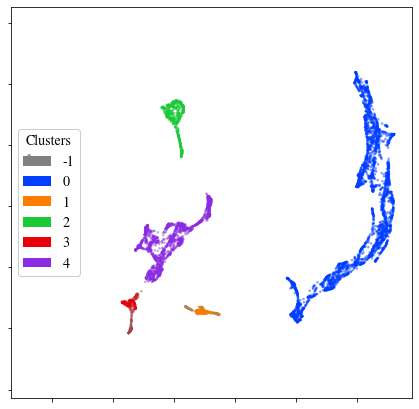

In [10]:
kf.plot_cluster_membership(
    embedding=embedding, 
    clusterer=clusterer,
    soft=False
)

As can be observed HDBSCAN has done a fantastic job in grouping the points by regions (i.e. clusters) in a similar way to what a human would do. Note that HDBSCAN can also detect noise if it thinks it exits in the dataset. Points considered as noise are classified into the -1 cluster, which is always plotted as grey by the `plot_cluster_membership` function. In this case, a small number of points near the top-left corner have been correctly classified as noise, as the original data had same intentionally corrupted points where all variables were set to zero. This algorithm also provides a membership value for each point dependant of the HDBSCAN's confidence the that point belong to the labeled cluster, which is presented with different opacities (higher for higher membership probability). 

As HDBSCAN is a hierarchical algorithm, we can see the substructure of the clusters by using the plotting function `show_condensed_tree`. More information about how to interpret this dendrogam can be found [here](https://hdbscan.readthedocs.io/en/latest/advanced_hdbscan.html).

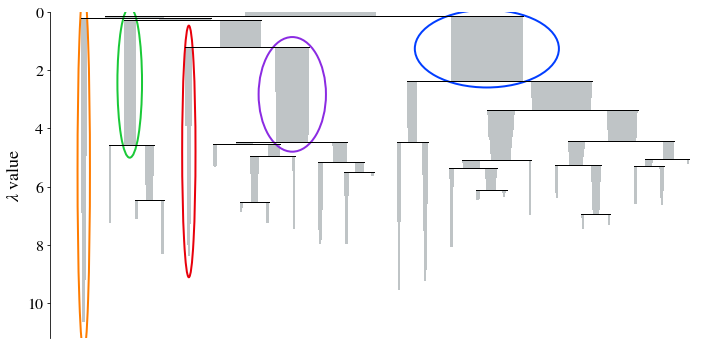

In [11]:
kf.show_condensed_tree(
    clusterer,
    select_clusters=True,
    label_clusters=False,
    leaf_separation=0.2,
    log_size=False
)

The last step of the key feature indentification process in `keyfi` is to obtain the feature correlation between the original variables (species' concentation, velocity and temperature) and the synthetic variables (the two UMAP components in the embedding) for each cluster. This will allow to understand why UMAP decided to cluster the dataset in the way it did as we can retrieve the most and least important variables in each cluster. Hence, we can automatically explain the original physics that make each region unique. 

To keep this short, we will look at just one cluster. This is done by mutual information (MI) which, unline linear correlation functions allows us to retrieve if there is any kind of correlation between variables. YOu can find more information about this algorithm in the `mi_tutorial.ipynb` notebook in the `algorithms` folder or in the [sklearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_regression.html).

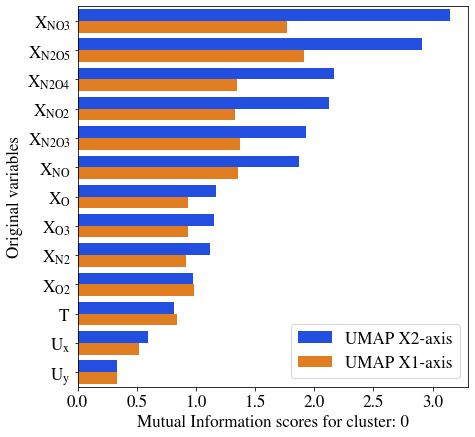

In [12]:
cluster_mi_scores = kf.get_cluster_mi_scores(
    data=cleaned_data, 
    clusterer=clusterer, 
    embedding=embedding, 
    cluster_num = 0, 
    scale = False, 
    flag_print = False
)
kf.plot_cluster_scores(cluster_mi_scores)

We can see that this cluster is defined by high variations in the concentration of N2O5 and the species that produce it or are intermediates of it (NO2, NO3 and N2O4) and low variations in velocity and temperature. Note that `keyfi` was able to provide an unsupervised data-driven classification of the reactor domain regions in terms of the most relevant physics. 

If we want to take a look at the physical location of each cluster we can export the data into a VTK file (which can be opened in Paraview) by using the `export_vtk_data`.

In [13]:
path_output = './output/clusters_umap_hdbscan'
kf.export_vtk_data(mesh=mesh, path=path_output, cluster_labels=clusterer.labels_)

### Trying out KMeans

Although HDBSCAN is the recommended clustering algorithm, you can also use the well-known KMeans algorithm in `keyfi`. Let's run the clustering step again and plot how the labeled embedding looks for the same UMAP low-dimensional map. 

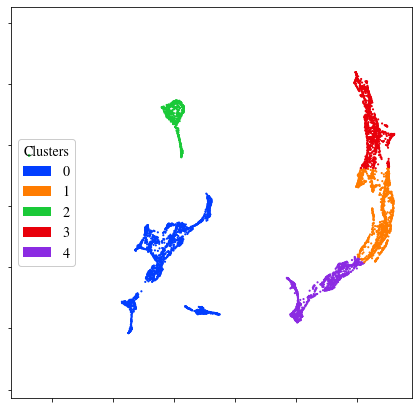

In [14]:
clusterer = kf.cluster_embedding(
    embedding=embedding,
    algorithm=KMeans,
    n_clusters=5,
    init='k-means++',
    max_iter=1000,
    n_init=100
)

kf.plot_clustering(
    embedding=embedding,
    cluster_labels=clusterer.labels_,
)

path_output = './output/clusters_umap_kmeans'
kf.export_vtk_data(mesh=mesh, path=path_output, cluster_labels=clusterer.labels_)

As you can see, KMeans produces much less intuitive results than HDBSCAN. It separates the rightmost region in a seemingly arbitrary way into three clusters. Also, it can't detect noise. It also doesn'r provide a membership value for each point (with respect to the cluster it thinks it forms part of) and so the `plot_clustering` function has to be used as oposed to the `plot_cluster_membership` function for a HDBSCAN clustering.

The physical location of the clusters with labels generated by UMAP and KMeans has also been exported as a VTK file. You can have a look at it in Paraview and compare it with the one produced by UMAP plus HDBSCAN.

### Trying out TSNE

Finally, we take a look at the TSNE algorithm for the embedding. Although UMAP is recommended, TSNE is also a decent option for the dimensionality reduction step. More information can be obtained in the [sklearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) or in the [website of it's creator](https://lvdmaaten.github.io/tsne/). Here, we repeater the embedding step with TSNE and clustered with HDBSCAN.

Apply scaling for all features.

Data reduction using algorithm: TSNE....

done in 20.503s.



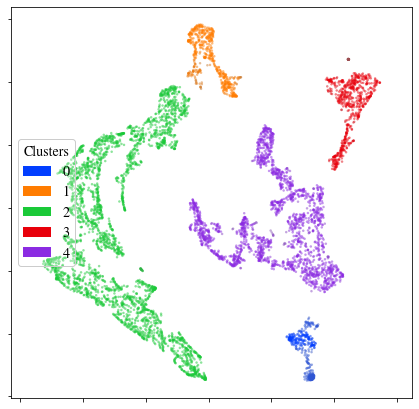

In [18]:
embedding, mapper = kf.embed_data(
    data=cleaned_data,
    algorithm=TSNE,
    scale=True,
    perplexity=80,
    n_components=2,
    init="pca"
)

clusterer = kf.cluster_embedding(
    embedding=embedding,
    algorithm=HDBSCAN,
    min_cluster_size=100,
    min_samples=10,
    prediction_data=True
)

kf.plot_cluster_membership(
    embedding=embedding, 
    clusterer=clusterer,
    soft=False
)

path_output = './output/clusters_tsne_hdbscan'
kf.export_vtk_data(mesh=mesh, path=path_output, cluster_labels=clusterer.labels_)

##### Parameter selection:

The two main parameters here when using TSNE is `perplexity`. Although each problem is different, we can use a some rule of thumb to get values for them that are quite useful.

- `perplexity`: this value in practice defines something like the number of neighbors that TSNE will use for defining the data structure. As a general rule, if $N$ is the total number of points in your dataset, a usefull value for the perplexity can be estimated as: $p \sim \sqrt{N}$. 

TSNE is less 'expressive' than UMAP, providing less densely packed clusters. This, among others, makes it much less robust to noise. TSNE is also slower than UMAP. You can have a look at the VTK file produced by TSNE and HDBSCAN and compare it with the others.